In [37]:
import warnings
warnings.filterwarnings('ignore')

In [38]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import pi
import cv2
import scipy.misc
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

In [39]:

DATA_FOLDER =  r"C:\Users\smrishar\Downloads\driving_dataset"
DATA_FILE = os.path.join(DATA_FOLDER, "data.txt")

x = []
y = []

train_batch_pointer = 0
test_batch_pointer = 0

In [40]:
with open(DATA_FILE) as f:
    for line in f:
        image_name, angle = line.split()
        
        image_path = os.path.join(DATA_FOLDER, image_name)
        x.append(image_path)
        
        angle_radians = float(angle) * (pi / 180)  #converting angle into radians
        y.append(angle_radians)
y = np.array(y)
print(str(len(x))+" "+str(len(y)))

45406 45406


In [41]:
split_ratio = int(len(x) * 0.8)

train_x = x[:split_ratio]
train_y = y[:split_ratio]

test_x = x[split_ratio:]
test_y = y[split_ratio:]

len(train_x), len(train_y), len(test_x), len(test_y)

(36324, 36324, 9082, 9082)

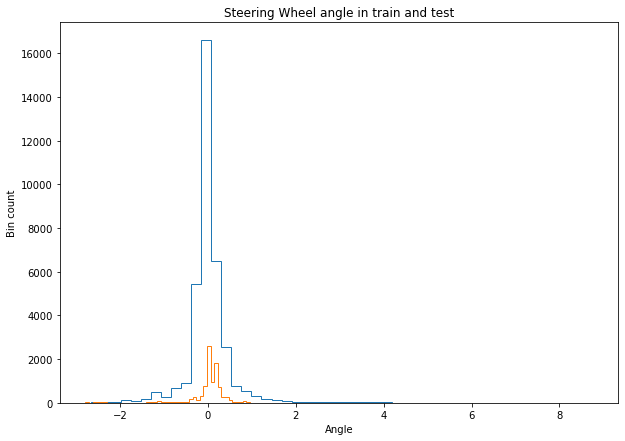

In [42]:
fig = plt.figure(figsize = (10, 7))
plt.hist(train_y, bins = 50, histtype = "step")
plt.hist(test_y, bins = 50, histtype = "step")
plt.title("Steering Wheel angle in train and test")
plt.xlabel("Angle")
plt.ylabel("Bin count")
plt.show()

In [43]:
def loadTrainBatch(batch_size):
    global train_batch_pointer
    x_result = []
    y_result = []
    for i in range(batch_size):
        read_image = cv2.imread(train_x[(train_batch_pointer + i) % len(train_x)]) #here % len(train_x) is used to make sure that
        #"train_batch_pointer + i" should not cross the number of train images. As soon as the value of "train_batch_pointer" is
        #equal to number of train images then it will again start reading the train images from the beginning means from 0th
        #index onwards.
        read_image_road = read_image[-150:] #here, we are taking only the lower part of the images where there is a road in the
        #image. As, we are concern only with the curves of the road to predict angles so therefore, we are discarding the upper
        #part of the image. Hence, here -"150" is equivalent to the last 150 matrix pixels of the image.
        read_image_resize = cv2.resize(read_image_road, (200, 66)) #After, resizing, each image will be of size (66, 200, 3). 
        #now since we have kept only the last 150 matrices in the image so the size of our image is now (150, 455, 3). 
        #Now 455/150 = 3.0303. Also 200/66 = 3.0303. Hence, here we are keeping the aspect ratio of images same.
        read_image_final = read_image_resize/255.0  #here, we are normalizing the images
        
        x_result.append(read_image_final) #finally appending the image pixel matrix
        
        y_result.append(train_y[(train_batch_pointer + i) % len(train_y)]) #appending corresponding labels
        
    train_batch_pointer += batch_size
        
    return x_result, y_result

In [44]:
def loadTestBatch(batch_size):
    global test_batch_pointer
    x_result = []
    y_result = []
    for i in range(batch_size):
        read_image = cv2.imread(test_x[(test_batch_pointer + i) % len(test_x)]) #here % len(test_x) is used to make sure that
        #"test_batch_pointer + i" should not cross the number of test images. As soon as the value of "test_batch_pointer" is
        #equal to number of test images then it will again start reading the test images from the beginning means from 0th
        #index onwards.
        read_image_road = read_image[-150:] #here, we are taking only the lower part of the images where there is a road in the
        #image. As, we are concern only with the curves of the road to predict angles so therefore, we are discarding the upper
        #part of the image. Hence, here -"150" is equivalent to the last 150 matrix pixels of the image.
        read_image_resize = cv2.resize(read_image_road, (200, 66)) #After, resizing, each image will be of size (66, 200, 3). 
        #now since we have kept only the last 150 matrices in the image so the size of our image is now (150, 455, 3). 
        #Now 455/150 = 3.0303. Also 200/66 = 3.0303. Hence, here we are keeping the aspect ratio of images same.
        read_image_final = read_image_resize/255.0  #here, we are normalizing the images
        
        x_result.append(read_image_final) #finally appending the image pixel matrix
        
        y_result.append(test_y[(test_batch_pointer + i) % len(test_y)]) #appending corresponding labels
        
    test_batch_pointer += batch_size
        
    return x_result, y_result


In [45]:
def weightVariable(shape):
    initial = tf.truncated_normal(shape = shape, stddev = 0.1)
    return tf.Variable(initial) 

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def convolution(previous_input, filter_input, strides):
    return tf.nn.conv2d(previous_input, filter_input, strides = [1, strides, strides, 1], padding = "VALID")

In [46]:
x_input = tf.placeholder(tf.float32, shape = [None, 66, 200, 3], name = "Plc_1")
y_true = tf.placeholder(tf.float32, name = "Plc_2")

input_image = x_input

In [47]:

#Convolution Layers
#First convolution layer
W_Conv1 = weightVariable([5,5,3,24])
B_Conv1 = bias_variable([24])
Conv1 = tf.nn.relu(convolution(input_image, W_Conv1, 2) + B_Conv1)
#strides = 2
#Output size: 31*98*24

#Second convolution layer
W_Conv2 = weightVariable([5,5,24,36])
B_Conv2 = bias_variable([36])
Conv2 = tf.nn.relu(convolution(Conv1, W_Conv2, 2) + B_Conv2)
#strides = 2
#Output size: 14*47*36

#Third convolution layer
W_Conv3 = weightVariable([5,5,36,48])
B_Conv3 = bias_variable([48])
Conv3 = tf.nn.relu(convolution(Conv2, W_Conv3, 2) + B_Conv3)
#strides = 2
#Output size: 5*22*48

#Fourth convolution layer
W_Conv4 = weightVariable([3,3,48,64])
B_Conv4 = bias_variable([64])
Conv4 = tf.nn.relu(convolution(Conv3, W_Conv4, 1) + B_Conv4)
#strides = 1
#Output size: 3*20*64


#Fifth convolution layer
W_Conv5 = weightVariable([3,3,64,64])
B_Conv5 = bias_variable([64])
Conv5 = tf.nn.relu(convolution(Conv4, W_Conv5, 1) + B_Conv5)
#strides = 1
#Output size: 1*18*64

#Fully-Connected Dense Layers
rate = tf.placeholder(tf.float32)
#First FC-Dense
#Input = 1*18*64 = 1152
W_FC1 = weightVariable([1152, 1164])
B_FC1 = bias_variable([1164])
FC1_Flatten = tf.reshape(Conv5, [-1, 1152]) #here, -1 indicates 1. It means that the shape of FC1_Flatten will be 1*1152
Output_FC1 = tf.nn.relu(tf.matmul(FC1_Flatten, W_FC1) + B_FC1) #so, here shape of FC1_Flatten is 1*1152 and shape of W_FC1 will
#be 1152*1164. Therefore, there will be a matrix multiplication of matrices: (1*1152) * (1152*1164) = (1*1164).
Output_FC1_drop = tf.nn.dropout(Output_FC1, rate)

#Second FC-Dense
#Input = 1*1164 = 1164
W_FC2 = weightVariable([1164, 100])
B_FC2 = bias_variable([100])
Output_FC2 = tf.nn.relu(tf.matmul(Output_FC1_drop, W_FC2) + B_FC2) #so, here shape of Output_FC1_drop is 1*1164 and shape of 
#W_FC2 will be 1164*100. Therefore, there will be a matrix multiplication of matrices: (1*1164) * (1164*100) = (1*100).
Output_FC2_drop = tf.nn.dropout(Output_FC2, rate)

#Third FC-Dense
#Input = 1*100 = 100
W_FC3 = weightVariable([100, 50])
B_FC3 = bias_variable([50])
Output_FC3 = tf.nn.relu(tf.matmul(Output_FC2_drop, W_FC3) + B_FC3) #so, here shape of Output_FC2_drop is 1*100 and shape of 
#W_FC3 will be 100*50. Therefore, there will be a matrix multiplication of matrices: (1*100) * (100*50) = (1*50).
Output_FC3_drop = tf.nn.dropout(Output_FC3, rate)

#Fourth FC-Dense
#Input = 1*50 = 50
W_FC4 = weightVariable([50, 10])
B_FC4 = bias_variable([10])
Output_FC4 = tf.nn.relu(tf.matmul(Output_FC3_drop, W_FC4) + B_FC4) #so, here shape of Output_FC3_drop is 1*50 and shape of 
#W_FC4 will be 50*10. Therefore, there will be a matrix multiplication of matrices: (1*50) * (50*10) = (1*10).
Output_FC4_drop = tf.nn.dropout(Output_FC4, rate)

#Final Output to one neuron with linear/identity function
#Input = 1*10 = 10
W_FC5 = weightVariable([10, 1])
B_FC5 = bias_variable([1])
y_predicted = tf.identity(tf.matmul(Output_FC4_drop, W_FC5) + B_FC5) #so, here shape of Output_FC4_drop is 1*10 and shape of 
#W_FC5 will be 10*1. Therefore, there will be a matrix multiplication of matrices: (1*10) * (10*1) = (1*1). Since, this is a 
#regression problem so we have applied identity fuction in the end. We can also apply "atan" function here. If computational
#power is available then the model should be tested with both identity and atan functions. In the end, that function should be
#considered which gives better result.

In [49]:

SAVEDIR = r"C:\Users\smrishar\Downloads\driving_dataset\Saver"
sess = tf.InteractiveSession()

L2NormConst = 0.001
train_vars = tf.trainable_variables() #it will return all the variables. Here, all the weights and biases are variables which
#are trainable.

loss = tf.reduce_mean(tf.square(tf.subtract(y_true, y_predicted))) + tf.add_n([tf.nn.l2_loss(w) for w in train_vars]) * L2NormConst
#since this is a regression problem so above loss is mean-squared-error loss
train_step = tf.train.AdamOptimizer(learning_rate = 10**-4).minimize(loss)
sess.run(tf.global_variables_initializer())

saver = tf.train.Saver()

epochs = 10
batch_size = 50
epoch_number, train_loss, test_loss,  = [], [], []

for epoch in range(epochs):
    train_avg_loss = 0
    test_avg_loss = 0
    te_loss_old = 10000  #any big number can be given
    
    for i in range(int(len(x)/batch_size)):
        train_batch_x, train_batch_y = loadTrainBatch(batch_size)
        train_step.run(feed_dict = {x_input: train_batch_x, y_true: train_batch_y, rate: 0.8})
        tr_loss = loss.eval(feed_dict = {x_input: train_batch_x, y_true: train_batch_y, rate: 1.0})
        train_avg_loss += tr_loss / batch_size
    
        test_batch_x, test_batch_y = loadTestBatch(batch_size)
        te_loss_new = loss.eval(feed_dict = {x_input: test_batch_x, y_true: test_batch_y, rate: 1.0})
        test_avg_loss += te_loss_new / batch_size
        
        if te_loss_new < te_loss_old:
            print("Epoch: {}, Train_Loss: {}, Test_Loss: {} *".format(epoch+1, tr_loss, te_loss_new))
        else:
            print("Epoch: {}, Train_Loss: {}, Test_Loss: {}".format(epoch+1, tr_loss, te_loss_new))
        te_loss_old = te_loss_new
        
        if (i+1) % batch_size == 0:
            if not os.path.exists(SAVEDIR):
                os.makedirs(SAVEDIR)
            save_path = os.path.join(SAVEDIR, "model.ckpt")
            saver.save(sess = sess, save_path = save_path)
            print("Model saved at location {} at epoch {}".format(save_path, epoch + 1))
        
    epoch_number.append(epoch)
    train_loss.append(train_avg_loss)
    test_loss.append(test_avg_loss)
    
#creating dataframe and record all the losses and accuracies at each epoch
log_frame = pd.DataFrame(columns = ["Epoch", "Train Loss", "Test Loss"])
log_frame["Epoch"] = epoch_number
log_frame["Train Loss"] = train_loss
log_frame["Test Loss"] = test_loss
log_frame.to_csv(os.path.join(SAVEDIR, "log.csv"), index = False)

Epoch: 1, Train_Loss: 18.505155563354492, Test_Loss: 18.506881713867188 *
Epoch: 1, Train_Loss: 18.49608612060547, Test_Loss: 18.498302459716797 *
Epoch: 1, Train_Loss: 18.439069747924805, Test_Loss: 18.496150970458984 *
Epoch: 1, Train_Loss: 18.424243927001953, Test_Loss: 18.49131965637207 *
Epoch: 1, Train_Loss: 18.386463165283203, Test_Loss: 20.159849166870117
Epoch: 1, Train_Loss: 18.355924606323242, Test_Loss: 25.18500518798828
Epoch: 1, Train_Loss: 18.320938110351562, Test_Loss: 19.92551612854004 *
Epoch: 1, Train_Loss: 18.29207420349121, Test_Loss: 18.304962158203125 *
Epoch: 1, Train_Loss: 18.264436721801758, Test_Loss: 18.28035545349121 *
Epoch: 1, Train_Loss: 18.232444763183594, Test_Loss: 18.23887825012207 *
Epoch: 1, Train_Loss: 18.204036712646484, Test_Loss: 18.202411651611328 *
Epoch: 1, Train_Loss: 18.172618865966797, Test_Loss: 18.174205780029297 *
Epoch: 1, Train_Loss: 18.143667221069336, Test_Loss: 18.143836975097656 *
Epoch: 1, Train_Loss: 18.114601135253906, Test_Lo